## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('dark')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

## Load the data
We set a few flags for whether we are running locally or on Kaggle, or whether we want the reduced or full dataset. For the reduced dataset, the test set consists of samples from the full train set. For use during model evaluation, this has been augmented with reverse-engineered targets. This is simply to allow us to evaluate the AUC score on this set as well - it is never used for training.

In [2]:
IS_LOCAL = True  # Sets whether we are running locally or on kaggle
USE_REDUCED = True  # Sets whether we should use the smaller dataset
data_index = 2*int(IS_LOCAL) + int(USE_REDUCED)
train_path = ('../input/santander-customer-transaction-prediction/train.csv',
             '../input/santandersmall/train_small.csv',
             'train.csv',
             'train_small.csv')[data_index]
test_path = ('../input/santander-customer-transaction-prediction/test.csv',
             '../input/santandersmall/test_small_with_targets.csv',
             'test.csv',
             'test_small.csv')[data_index]

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [3]:
features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
if not 'target' in test_df:
    test_df['target'] = -1

all_df = pd.concat([train_df, test_df], sort=False)

## Exploratory Data Analysis
After loading the data, the first step is to start familiarizing ourselves with the data set. This is done through what we call an Exploratory Data Analysis (EDA for short), where we simply produce a lot of metrics and visualizations of the data, trying to get a better picture of what is going on.

We begin by simply looking at the dimensions and some samples of our data.

In [4]:
train_df.shape

(70057, 202)

In [5]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
1,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
2,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
3,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
4,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097


In [6]:
test_df.shape

(70065, 202)

In [7]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,-1
1,train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996,-1
2,train_7,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,5.0647,...,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806,-1
3,train_12,8.7671,-4.6154,9.7242,7.4242,9.0254,1.4247,6.2815,12.3143,5.6964,...,7.4382,0.0854,1.3444,17.2439,-0.0798,5.7389,8.4897,17.0938,4.6106,-1
4,train_14,13.8080,5.0514,17.2611,8.5120,12.8517,-9.1622,5.7327,21.0517,-4.5117,...,8.3220,3.2619,1.6738,17.4797,-0.0257,-3.5323,9.3439,24.4479,-5.1110,-1


We see that the data set contains a single target, which we know from the data description is binary, and a quite large number of 200 numerical features. We do not have any knowledge about what these features represent.

### Target Distribution
Next we look at the distribution of different target values in the train set:

Fraction of positive samples: 9.97%


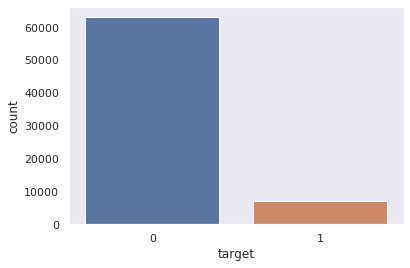

In [8]:
sns.countplot(train_df['target'])
positive_frac = train_df['target'].sum() / train_df.shape[0]
print(f'Fraction of positive samples: {positive_frac:.2%}')

We see that the distribution of targets is somewhat imbalanced, with only about 10% of the samples being positive. An important consequence of this is that a classifier that makes a negative prediction on all samples would achieve an accuracy of ~90%! However, we will ROC AUC as an evaluation metric, which describes the classifier's ability to assign a higher probability to positive than to negative samples, and is therefore less influenced by such an imbalance. We can consider applying techniques to balance the dataset, but based on the classification technique, this is not always necessary.

### Missing Values
A typical problem with several data sets is missing values due to for example communication or hardware errors. Below, we do a quick check for missing values in our data set.

In [9]:
print(f'Missing values in train set: {train_df.isna().sum().sum()}')
print(f'Missing values in test set: {test_df.isna().sum().sum()}')

Missing values in train set: 0
Missing values in test set: 0


Neither the train set nor the test set contain missing values, so we do not need to handle this in any way.

### Statistical Properties
Below, we use the pandas describe() method to produce a number of statistical properties of our data.

In [10]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,...,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000
mean,0.099733,10.678757,-1.625370,10.718501,6.801363,11.080280,-5.099666,5.412131,16.557562,0.284365,...,3.257023,7.444208,1.927193,3.328773,18.008622,-0.140578,2.298631,8.906114,15.869843,-3.323176
std,0.299646,3.037911,4.060012,2.629766,2.043351,1.627265,7.887190,0.867160,3.422813,3.335973,...,4.540336,3.018182,1.481911,3.988392,3.138089,1.427751,5.460012,0.920043,3.014017,10.438217
min,0.000000,0.597900,-15.043400,2.615000,-0.040200,5.490200,-29.777300,2.347300,5.349700,-9.905100,...,-13.999500,-2.009400,-3.566800,-11.783400,9.594900,-4.644200,-14.020400,5.960600,6.299300,-38.852800
25%,0.000000,8.461000,-4.751700,8.742600,5.252000,9.877400,-11.271800,4.768100,13.951300,-2.335100,...,-0.022800,5.161900,0.886300,0.587800,15.640500,-1.164000,-1.956100,8.253600,13.819700,-11.236200
50%,0.000000,10.526500,-1.614100,10.589100,6.837700,11.113000,-4.844100,5.387400,16.464600,0.409100,...,3.231400,7.341700,1.899100,3.387100,17.975900,-0.169000,2.390700,8.886000,15.931700,-2.800100
75%,0.000000,12.749600,1.371600,12.505900,8.333400,12.268000,0.907600,6.005500,19.119800,2.946300,...,6.410200,9.529300,2.952300,6.206400,20.421000,0.828300,6.573400,9.589400,18.071500,4.855300
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,16.806500,8.447700,27.638900,9.482200,...,18.342300,16.684600,7.611600,17.908600,27.928800,4.075600,16.226600,11.843900,26.079100,27.531900


In [11]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
count,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,...,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.0
mean,10.673473,-1.636284,10.716429,6.789705,11.075697,-5.040173,5.406073,16.531615,0.287496,7.561346,...,7.434805,1.929542,3.306963,17.985451,-0.144594,2.292337,8.913608,15.875528,-3.363418,-1.0
std,3.038395,4.043325,2.645041,2.042268,1.622335,7.864192,0.867739,3.413390,3.329416,1.238668,...,3.025254,1.478161,3.985700,3.144663,1.426939,5.442084,0.922834,3.013491,10.458007,0.0
min,0.452800,-14.696200,2.117100,0.255000,5.074800,-32.562600,2.495700,6.465300,-10.505500,4.177100,...,-2.343000,-3.814500,-10.828300,8.694400,-5.018500,-13.885900,6.143200,6.644800,-38.852800,-1.0
25%,8.443200,-4.745900,8.718200,5.250600,9.886400,-11.161400,4.764700,13.933300,-2.306100,6.604600,...,5.153000,0.895000,0.563300,15.613300,-1.173900,-1.953300,8.255200,13.835100,-11.227900,-1.0
50%,10.510400,-1.613400,10.580600,6.816300,11.108100,-4.820800,5.381800,16.435100,0.395100,7.619900,...,7.346800,1.899700,3.379800,17.937000,-0.176100,2.390600,8.890100,15.950100,-2.871800,-1.0
75%,12.767100,1.324400,12.523700,8.306400,12.255000,0.948800,6.003600,19.093000,2.932600,8.579700,...,9.500200,2.951800,6.179200,20.399200,0.827700,6.524600,9.600300,18.070600,4.831400,-1.0
max,19.998400,10.167100,18.412700,13.098300,15.991400,17.128100,8.285200,27.691800,10.151300,11.150600,...,16.541100,8.402400,18.281800,27.597300,4.255700,17.684100,11.851100,26.034600,28.500700,-1.0


The different data points have varying mean and standard deviation values. During preprocessing, we will look into normalizing this, which can often speed up training.

### Feature Distributions
Below, we plot distributions of all values across the train and test sets in order to see if there are any significant differences.

*Note: The next couple of plots are huge, creating individual plots for each of 200 features. As such, running them can take a significant amount of time.*

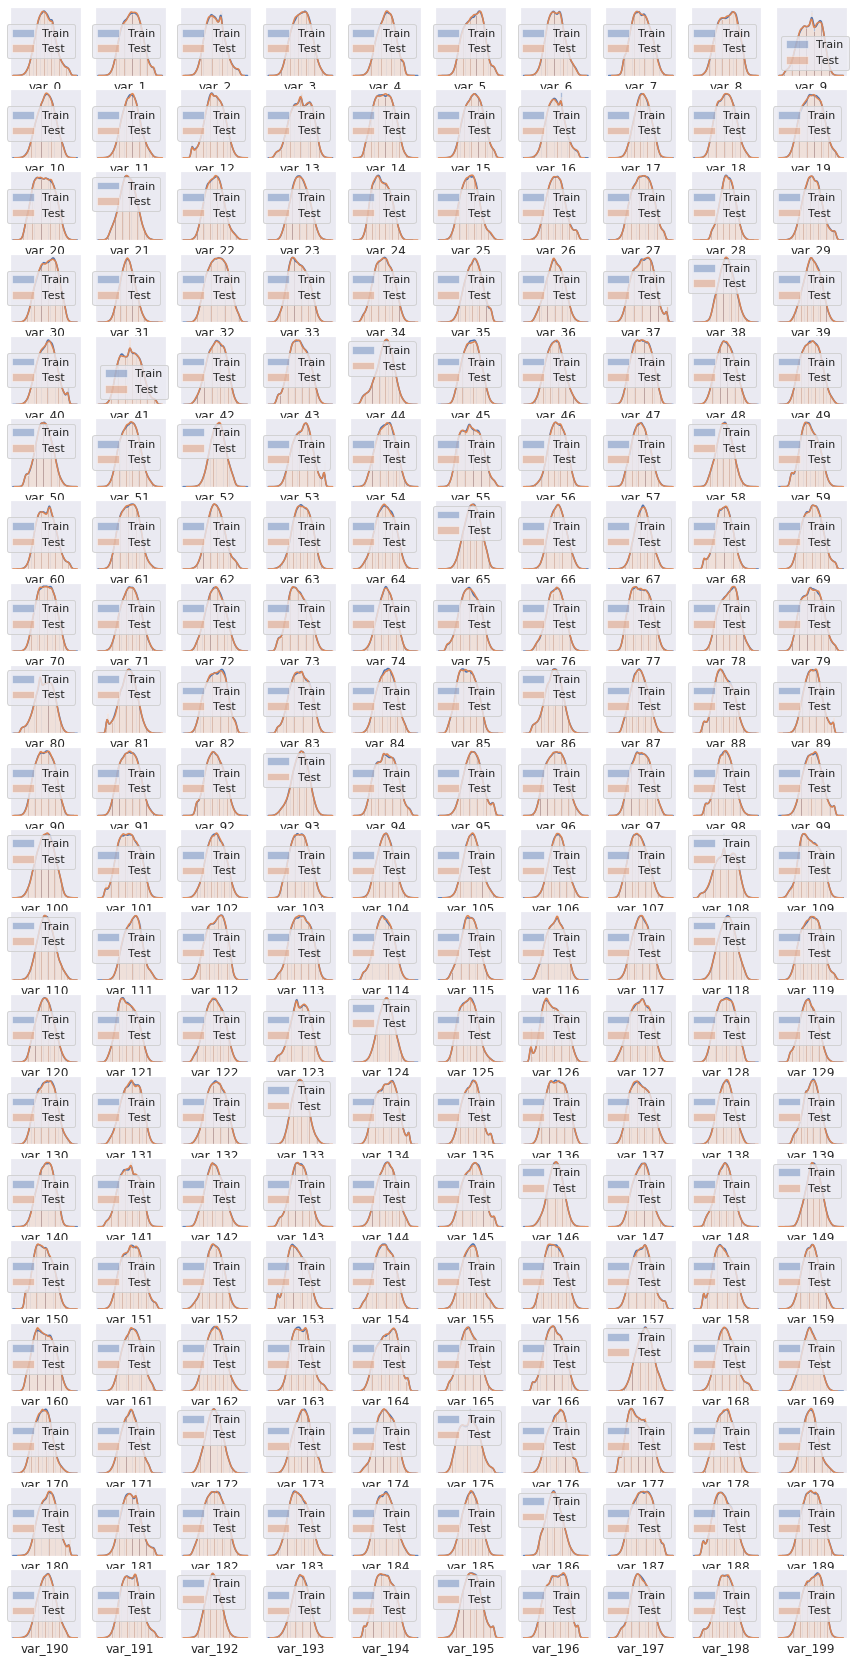

In [12]:
plt.figure(figsize=(15, 30))
i = 0
for feature in tqdm(features):
    i += 1
    plt.subplot(20, 10, i)
    plt.xticks([])
    plt.yticks([])
    sns.distplot(train_df[feature], label='Train')
    sns.distplot(test_df[feature], label='Test')
    plt.xlabel(feature)
    plt.legend()
plt.show()

The train and test sets appear to be fairly equally distributed across all features. This is good, as it indicates that we should be able to generalize from the train to the test set. Any significant differences would indicate that the train set is not representative, and would therefore be problematic.

The next plot is quite similar, instead showing the difference in distributions between samples with negative and positive target values.

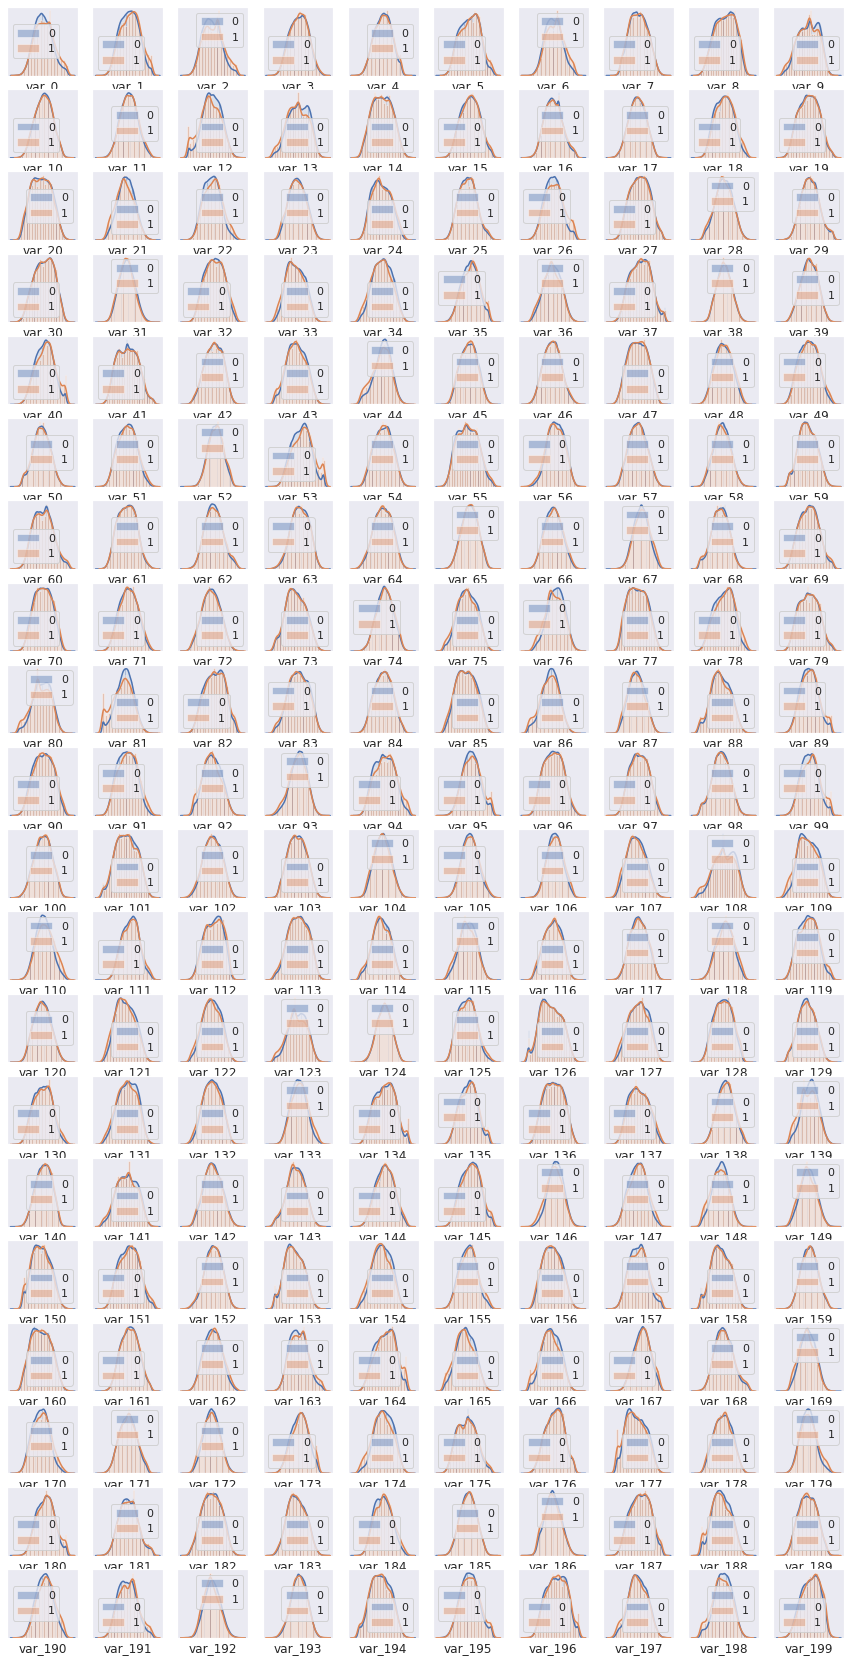

In [13]:
plt.figure(figsize=(15, 30))
i = 0
for feature in tqdm(features):
    i += 1
    plt.subplot(20, 10, i)
    plt.xticks([])
    plt.yticks([])
    sns.distplot(train_df[train_df['target'] == 0][feature], label='0')
    sns.distplot(train_df[train_df['target'] == 1][feature], label='1')
    plt.xlabel(feature)
    plt.legend()
plt.show()

When comparing the distributions between different target values, we start to see some differences. This is also positive, as it indicates that there is indeed some difference between negative and positive samples. This difference is what we are hoping to identify with our classifier. However, no single feature offers a very large difference, so we will have to expect to use a number of different features in order to classify correctly.

### Mean and Standard Deviation of Samples
The below plots are similar to the ones above, but instead use aggregated mean and STD values, making them easier to evaluate at a glance.

We first plot mean and STD filtered by data set:

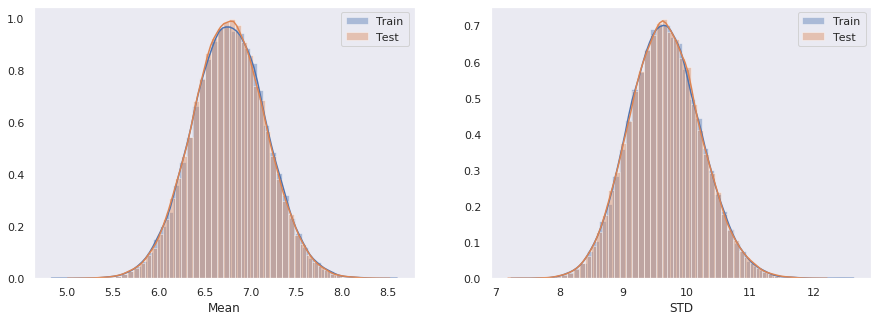

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.distplot(train_df[features].mean(axis=1), label='Train')
sns.distplot(test_df[features].mean(axis=1), label='Test')
plt.legend()
plt.xlabel('Mean')

plt.subplot(122)
sns.distplot(train_df[features].std(axis=1), label='Train')
sns.distplot(test_df[features].std(axis=1), label='Test')
plt.legend()
plt.xlabel('STD')

plt.show()

We then do the same, but now over only the train set, and filtered by target value:


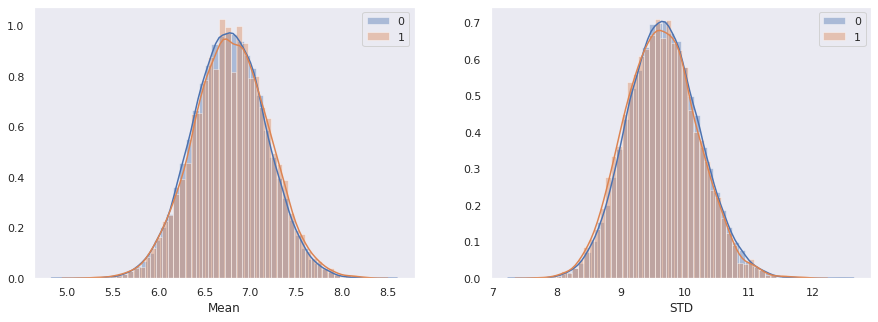

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.distplot(train_df[train_df['target'] == 0][features].mean(axis=1), label='0')
sns.distplot(train_df[train_df['target'] == 1][features].mean(axis=1), label='1')
plt.legend()
plt.xlabel('Mean')

plt.subplot(122)
sns.distplot(train_df[train_df['target'] == 0][features].std(axis=1), label='0')
sns.distplot(train_df[train_df['target'] == 1][features].std(axis=1), label='1')
plt.legend()
plt.xlabel('STD')

plt.show()

These plots confirm the observations from above. When comparing train and test sets, the difference is fortunately quite small, indicating that the train set samples are representative. The difference is slightly bigger when looking at the values filtered by target. However, the difference is less clear now, since we are looking at aggregated values, which as can be expected smoothes out the difference somewhat.

### Feature Correlations
We now have a look at correlations between features, and between the features and the target values.

In [16]:
corr = train_df[features].corr()
corr = corr.abs().unstack().reset_index()
corr = corr[corr['level_0'] != corr['level_1']]
corr = corr.sort_values(by=0)

First, we look at the most correlated pairs of features:

In [17]:
corr.tail(10).iloc[::-1]

,level_0,level_1,0
415,var_2,var_15,0.014829
3002,var_15,var_2,0.014829
6946,var_34,var_146,0.014604
29234,var_146,var_34,0.014604
29889,var_149,var_89,0.014604
17949,var_89,var_149,0.014604
6934,var_34,var_134,0.014548
26834,var_134,var_34,0.014548
19449,var_97,var_49,0.014378
9897,var_49,var_97,0.014378


We then have a look at the least correlated pairs of features:

In [18]:
corr.head(10)

,level_0,level_1,0
6268,var_31,var_68,4.370327e-07
13631,var_68,var_31,4.370327e-07
3072,var_15,var_72,1.151774e-06
14415,var_72,var_15,1.151774e-06
30531,var_152,var_131,1.162002e-06
26352,var_131,var_152,1.162002e-06
1684,var_8,var_84,1.807790e-06
16808,var_84,var_8,1.807790e-06
11285,var_56,var_85,2.051344e-06
17056,var_85,var_56,2.051344e-06


None of the features are strongly correlated with each other. This is typically good, as some classification methods are sensitive to features with high correlations.

Next up, we calculate the correlations between individual features and the target:

In [19]:
corr2 = train_df[features].corrwith(train_df['target'])
corr2 = corr2.abs().reset_index()
corr2 = corr2.sort_values(by=0)
corr2.tail(10).iloc[::-1]

,index,0
81,var_81,0.080997
139,var_139,0.070490
53,var_53,0.068790
12,var_12,0.066019
110,var_110,0.065921
6,var_6,0.064283
146,var_146,0.064117
26,var_26,0.063510
174,var_174,0.061070
22,var_22,0.060991


In [20]:
corr2.head(10)

,index,0
39,var_39,0.000176
185,var_185,0.000648
30,var_30,0.000866
126,var_126,0.000945
160,var_160,0.001560
129,var_129,0.002059
38,var_38,0.002078
176,var_176,0.002303
189,var_189,0.002458
61,var_61,0.002714


Here, the correlations are somewhat higher, which is generally good, as it shows that the features influence the target value. It should be noted, however, that the correlations only give an indication of linear dependencies. We can expect there to be more complex dependencies. We here also only look at the relations between single features and the target. since the correlations are still quite low, we hope that looking at several features at once will reveal more information.

## Pre-Processing and Feature Engineering
An important part of machine learning is preparing the data set. In this section, we apply several techniques in order to facility the training of our classifiers. These techniques include normalization and engineering new features from our existing ones.

### Removing fake test samples
It was discovered during the competition that some of the test samples were synthetic. Moreover, it was stated that not all of the data in the test set was used for evaluation, and the synthetic data corresponds to this. In order to achieve the best scores possible, the fake samples should be removed before calculating features such as counts. We calculate the indices of the fake rows below using the method provided by the Kaggle user YaG320. When using the reduced dataset, we have no synthetic samples. This is handled correctly by the algorithm below.

In [21]:
unique_count = np.zeros((test_df.shape[0], len(features)))

for f, feature in tqdm(enumerate(features), total=len(features)):
    _, i, c = np.unique(test_df[feature], return_counts=True, return_index=True)
    unique_count[i[c == 1], f] += 1

real_sample_indices = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_sample_indices = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]
print('Real:', len(real_sample_indices))
print('Synthetic:', len(synthetic_sample_indices))

del unique_count


Real: 70065
Synthetic: 0


### Calculate counts
Counts of the values of the different features is often a powerful feature in itself. We calculate these below.

In [22]:
all_real_df = pd.concat([train_df, test_df.iloc[real_sample_indices, :]], sort=False)

for feature in tqdm(features):
    real_series = all_real_df[feature]
    
    # We only use the real samples to produce the count
    counts = real_series.groupby(real_series).count()
    
    full_series = all_df[feature]
    all_df[f'{feature}_count'] = full_series.map(counts)

del all_real_df
del real_series
del full_series

### Statistical Properties
Some statistical properties of the rows of data can also help the classifier make correct predictions by revealing connections that may otherwise be difficult to discover.

In [23]:
all_df['sum'] = all_df[features].sum(axis=1)
all_df['mean'] = all_df[features].mean(axis=1)
all_df['min'] = all_df[features].min(axis=1)
all_df['max'] = all_df[features].max(axis=1)
all_df['std'] = all_df[features].std(axis=1)
all_df['median'] = all_df[features].median(axis=1)
all_df['skew'] = all_df[features].skew(axis=1)
all_df['kurt'] = all_df[features].kurt(axis=1)

statistical_features = ['mean', 'min', 'max', 'std', 'median', 'skew', 'kurt']
# Due to normalization, mean and sum become the same value, so we only include one of them

### Normalization
Normalizing features can often speed up the training of our classifier, as it does not need to deal with hugely varying scales. We apply two types of normalization below. All the numerical features and the statistical properties are normalized to have zero mean, unit variance. The counts are normalized to be between zero and one.

In [24]:
for feature in tqdm(features + statistical_features):
    if feature in features:
        all_df[feature] = StandardScaler().fit_transform(all_df[feature].values.reshape(-1, 1))
        all_df[f'{feature}_count'] = MinMaxScaler().fit_transform(all_df[f'{feature}_count'].values.reshape(-1, 1))
    if feature in statistical_features:
        all_df[feature] = StandardScaler().fit_transform(all_df[feature].values.reshape(-1, 1))

### Update feature list
We update the feature list with our new features, so that they are included in training and prediction.

In [25]:
for f in range(len(features)):
    features.append(f'{features[f]}_count')
features.extend(statistical_features)

### Splitting datasets back up
We are now done with our feature engineering, so we can split the data back into train and test sets.

In [26]:
train_df = all_df.iloc[:train_df.shape[0], :]
test_df = all_df.iloc[train_df.shape[0]:, :]

del all_df

## Model Selection
Below, a number of different classification methods are trained on the data. Due to personal experience and knowledge, I chose to focus on the neural network model. Therefore, the results are not directly comparable, and it may be possible to achieve as good results with some of the other techniques if the necessary tuning is applied.

### Support Vector Machine
Support Vector Machines are a classic technique for machine learning with some nice characteristics, such as providing a convex optimization problem. They have been successfully applied to a range of problems, such as voice recognition (although in many areas they have been replaced by neural networks in recent years).

A single SVM is a quite simple model, however, so I do not expect it to perform particularly well here. Nonetheless, it is a good starting point before trying more advanced methods.

In [27]:
# N_SPLITS = 5

# params = {
#     'kernel': 'rbf',
#     'gamma': 'auto',
#     'verbose': True,
#     'random_state': 42,
#     'max_iter': 5000,
# }

# oof_preds_sum = np.zeros((train_df.shape[0],))
# train_preds_sum = np.zeros((train_df.shape[0],))
# test_preds_sum = np.zeros((test_df.shape[0],))

# kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# for fold_num, (train_index, val_index) in tqdm(enumerate(kfold.split(train_df[features].values, train_df['target'].values)), total=N_SPLITS):    
#     print(f'Fold {fold_num+1}/{N_SPLITS}')
    
#     X_train = train_df.loc[train_index, features].values
#     y_train = train_df.loc[train_index, 'target'].values
#     X_val = train_df.loc[val_index, features].values
#     y_val = train_df.loc[val_index, 'target'].values
    
#     model = SVC(**params)
#     model.fit(X_train, y_train)
    
#     val_preds = model.predict(X_val)
#     train_preds = model.predict(X_train)
#     test_preds = model.predict(test_df[features].values)
    
#     val_auc = roc_auc_score(y_val, val_preds)
#     train_auc = roc_auc_score(y_train, train_preds)
    
#     print(f'Train AUC: {train_auc}')
#     print(f'Validation AUC: {val_auc}')
    
#     oof_preds_sum[val_index] += val_preds
#     train_preds_sum[train_index] += train_preds
#     test_preds_sum += test_preds
#     print()

### Random Forest
Random Forests is an ensemble method based on Decision Trees. A big problem with decision trees is their tendency to overfit, since all decisions are hard. With a Random Forest, we train a large number of decision trees on different random subsets of features. It can as such be seen as a special case of bagging, called feature bagging. By limiting the number of available features, we train weaker models, but with less danger of overfitting. The predictive power of the model comes from the entire ensemble, as we make predictions by taking an aggregate of individual model predictions.

We start by running a parameter search. This will fit a significant number of classifiers with different hyperparameters in order to find the best performing combination of parameters. Due to the large search space, this operation takes quite a long time.

In [28]:
# N_SPLITS = 5

# random_grid = {
#     'n_estimators': [10, 25, 50, 75, 100, 150, 200],
#     'max_depth': [10, 15, 20, 25, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'bootstrap': [True, False],
# }

# rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42, criterion='entropy'), 
#                               param_distributions=random_grid,
#                               n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1,
#                               return_train_score=True)

# rf_random.fit(train_df[features].values, train_df['target'].values)

Below, we use the best parameters returned by the above parameter search to fit a model on the dataset:

In [29]:
# params = {
#     'n_estimators': 100,
#     'criterion': 'entropy',
#     'max_depth': 15,
    
#     'n_jobs': -1,
#     'random_state': 42
# }


# oof_preds_sum = np.zeros((train_df.shape[0],))
# train_preds_sum = np.zeros((train_df.shape[0],))
# test_preds_sum = np.zeros((test_df.shape[0],))

# kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# for fold_num, (train_index, val_index) in tqdm(enumerate(kfold.split(train_df[features].values, train_df['target'].values)), total=N_SPLITS):    
#     print(f'Fold {fold_num+1}/{N_SPLITS}')
    
#     X_train = train_df.loc[train_index, features].values
#     y_train = train_df.loc[train_index, 'target'].values
#     X_val = train_df.loc[val_index, features].values
#     y_val = train_df.loc[val_index, 'target'].values
    
#     model = RandomForestClassifier(**params)
#     model.fit(X_train, y_train)
    
#     val_preds = model.predict(X_val)
#     train_preds = model.predict(X_train)
#     test_preds = model.predict(test_df[features].values)
    
#     val_auc = roc_auc_score(y_val, val_preds)
#     train_auc = roc_auc_score(y_train, train_preds)
    
#     print(f'Train AUC: {train_auc}')
#     print(f'Validation AUC: {val_auc}')
    
#     oof_preds_sum[val_index] += val_preds
#     train_preds_sum[train_index] += train_preds
#     test_preds_sum += test_preds
#     print()

### AdaBoost
AdaBoost is a simple boosting algorithm, where the ensemble is trained sequentially, with the performance of previous models taken into account when training new models. AdaBoost works by assigning weights to the different samples, with previously misclassified samples given the highest weights. The idea is that new classifiers will learn to classify the samples that previous classifiers misclassified, improving the performance of the ensemble. AdaBoost can use any type of model that can accept sample weights as a base classifier, but is typically used with decision trees.

In [30]:
# N_SPLITS = 5

# params = {
#     'n_estimators': 50,
#     'learning_rate': 0.5,
#     'algorithm': 'SAMME.R',
    
#     'random_state': 42
# }

# oof_preds_sum = np.zeros((train_df.shape[0],))
# train_preds_sum = np.zeros((train_df.shape[0],))
# test_preds_sum = np.zeros((test_df.shape[0],))

# kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# for fold_num, (train_index, val_index) in tqdm(enumerate(kfold.split(train_df[features].values, train_df['target'].values)), total=N_SPLITS):    
#     print(f'Fold {fold_num+1}/{N_SPLITS}')
    
#     X_train = train_df.loc[train_index, features].values
#     y_train = train_df.loc[train_index, 'target'].values
#     X_val = train_df.loc[val_index, features].values
#     y_val = train_df.loc[val_index, 'target'].values
    
#     model = AdaBoostClassifier(**params)
#     model.fit(X_train, y_train)
    
#     val_preds = model.predict(X_val)
#     train_preds = model.predict(X_train)
#     test_preds = model.predict(test_df[features].values)
    
#     val_auc = roc_auc_score(y_val, val_preds)
#     train_auc = roc_auc_score(y_train, train_preds)
    
#     print(f'Train AUC: {train_auc}')
#     print(f'Validation AUC: {val_auc}')
    
#     oof_preds_sum[val_index] += val_preds
#     train_preds_sum[train_index] += train_preds
#     test_preds_sum += test_preds
#     print()

### Neural Network

Neural networks are a really powerful class of classifiers that have proved effective at a large number of tasks. They are very powerful, but are notoriously hard to train, often requiring careful hyperparameter tuning in order to be effective. However, they are also the type of classifiers that I have most experience with, and therefore the one that I chose to focus on.

Below, we use a neural network model to make predictions. 5-fold stratified cross validation is used, and we rely on early stopping, setting a large default number of epochs of 100. Binary cross-entropy is used for the loss function, which is a good fit for a binary classification task such as this one. The output of the network is a single output from a sigmoid function, which can be interpreted as a probability. The goal is then to give a high probability to positive samples, and low probability to negative samples. The ability of the network to assign higher probabilities to positive than to negative classes is effectively measured by the ROC AUC metric. This is the metric that we use for early stopping. (However, using the cross entropy loss for early stopping as well should make little difference. Note that the requirements for the loss is different than for evaluation metrics due to requirement of differentiability.)

In [31]:
def get_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((len(features) * 1, 1), input_shape=(len(features) * 1,)),
        tf.keras.layers.Conv1D(32, 1, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, 1, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        #tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        #tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    return model

#### Adding Regularization
The above network has a problem with overfitting. It fits the training data really well, but the validation performance is much poorer. Below, we add L2 regularization, which penalizes features with little importance so that they are almost ignored. Dropout regularization was also tested, but L2 regularization proved more effective. 

With regularization, the model generalizes really well, with almost no difference between train and validation AUC. This means that we can train the model longer, and still get improvements on validation AUC, which will boost total performance.

In [32]:
def get_regularized_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((len(features) * 1, 1), input_shape=(len(features) * 1,)),
        tf.keras.layers.Conv1D(32, 1, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, 1, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
        #tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        #tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    return model

In [33]:
N_SPLITS = 5
BATCH_SIZE = 256
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 8

OPTIMIZER = tf.keras.optimizers.Nadam()
LOSS='binary_crossentropy'
METRICS=[tf.keras.metrics.AUC()]

model_fn = get_regularized_cnn_model

In [ ]:
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Due to memory issues with saving all models, we instead make the predictions as each fold is trained.
#models = []
histories = []
oof_preds_sum = np.zeros((train_df.shape[0],))
train_preds_sum = np.zeros((train_df.shape[0],))
test_preds_sum = np.zeros((test_df.shape[0],))

for fold_num, (train_index, val_index) in tqdm(enumerate(kfold.split(train_df[features].values, train_df['target'].values)), total=N_SPLITS):
    print(f'Fold {fold_num+1}/{N_SPLITS}:')
    
    X_train = train_df.loc[train_index, features].values
    y_train = train_df.loc[train_index, 'target'].values.reshape(-1, 1)
    X_val = train_df.loc[val_index, features].values
    y_val = train_df.loc[val_index, 'target'].values.reshape(-1, 1)
    
    model = model_fn()
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping_callback])
    histories.append(history)
    
    
    print(f'Creating predictions for fold {fold_num + 1}/{N_SPLITS}')
    val_preds = model.predict(X_val)
    train_preds = model.predict(X_train)
    test_preds = model.predict(test_df[features].values)
    
    oof_preds_sum[val_index] += val_preds[:, 0]
    train_preds_sum[train_index] += train_preds[:, 0]
    test_preds_sum += test_preds[:, 0]
    
    val_auc = roc_auc_score(y_val, val_preds)
    print(f'Fold validation AUC: {val_auc}')
    print()
    #models.append(model)

Fold 1/5:
Train on 56045 samples, validate on 14012 samples
Epoch 1/100
56045/56045 [==============================] - 24s 426us/sample - loss: 2.5632 - auc: 0.7391 - val_loss: 1.0295 - val_auc: 0.4991
Epoch 2/100
56045/56045 [==============================] - 17s 304us/sample - loss: 0.6142 - auc: 0.8385 - val_loss: 0.6509 - val_auc: 0.5351
Epoch 3/100
56045/56045 [==============================] - 17s 303us/sample - loss: 0.3795 - auc: 0.8420 - val_loss: 0.4349 - val_auc: 0.8215
Epoch 4/100
56045/56045 [==============================] - 17s 305us/sample - loss: 0.3518 - auc: 0.8458 - val_loss: 0.3692 - val_auc: 0.8389
Epoch 5/100
56045/56045 [==============================] - 17s 307us/sample - loss: 0.3629 - auc: 0.8453 - val_loss: 0.3689 - val_auc: 0.8399
Epoch 6/100
56045/56045 [==============================] - 17s 305us/sample - loss: 0.3762 - auc: 0.8476 - val_loss: 0.3840 - val_auc: 0.8402
Epoch 7/100
56045/56045 [==============================] - 17s 304us/sample - loss: 0.40

### Training plots

In [ ]:
plt.figure(figsize=(20, 5 * (len(histories) // 5 + 1)))
for i, h in enumerate(histories):
    plt.subplot(len(histories) // 5 + 1, 5, i+1)
    plt.plot(h.history['loss'], label='Train loss')
    plt.plot(h.history['val_loss'], label='Val loss')
    plt.plot(h.history['auc'], label='Train AUC')
    plt.plot(h.history['val_auc'], label='Val AUC')
    plt.legend()

## Evaluate performance

In [ ]:
train_preds_sum /= N_SPLITS
oof_preds_sum /= N_SPLITS
test_preds_sum /= N_SPLITS

In [ ]:
train_auc = roc_auc_score(train_df['target'], train_preds_sum)
oof_auc = roc_auc_score(train_df['target'], oof_preds_sum)
print(f'Train AUC: {train_auc}')
print(f'Out of fold AUC: {oof_auc}')

Often, a confusion matrix can help us better understand the performance of the model:

In [ ]:
pd.crosstab(train_df['target'], oof_preds_sum, rownames=['Actual'], colnames=['predicted'])

In [ ]:
pd.crosstab(train_df['target'], train_preds_sum, rownames=['Actual'], colnames=['predicted'])

We attempt to load the small test set with targets (reverse engineered from train set), which allows us to evaluate test set performance.

In [ ]:
try:
    test_df = pd.read_csv('test_small_with_targets.csv')
except FileNotFoundError:
    pass

In [ ]:
if test_df['target'][0] != -1:
    test_auc = roc_auc_score(test_df['target'], test_preds_sum)
    print(f'Test AUC: {test_auc}')

### Create submission

In [ ]:
sub = pd.DataFrame({'ID_code': test_df['ID_code'], 'target': test_preds_sum})
sub.to_csv('submission.csv', index=False)

In [ ]:
from IPython.display import FileLink
FileLink('submission.csv')

## Competition Results
The neural network model was also trained on the entire dataset, and the test set predictions submitted to the Kaggle competition. It achieved a score of 0.89706 on the private dataset, and 0.89770 on the public data set. This places it at around the middle of the leaderboard. The notebook with the scores is available on Kaggle at this link: https://www.kaggle.com/lagostra/cnn-2/notebook